In [54]:
import os
import re
import json
import multiprocessing
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

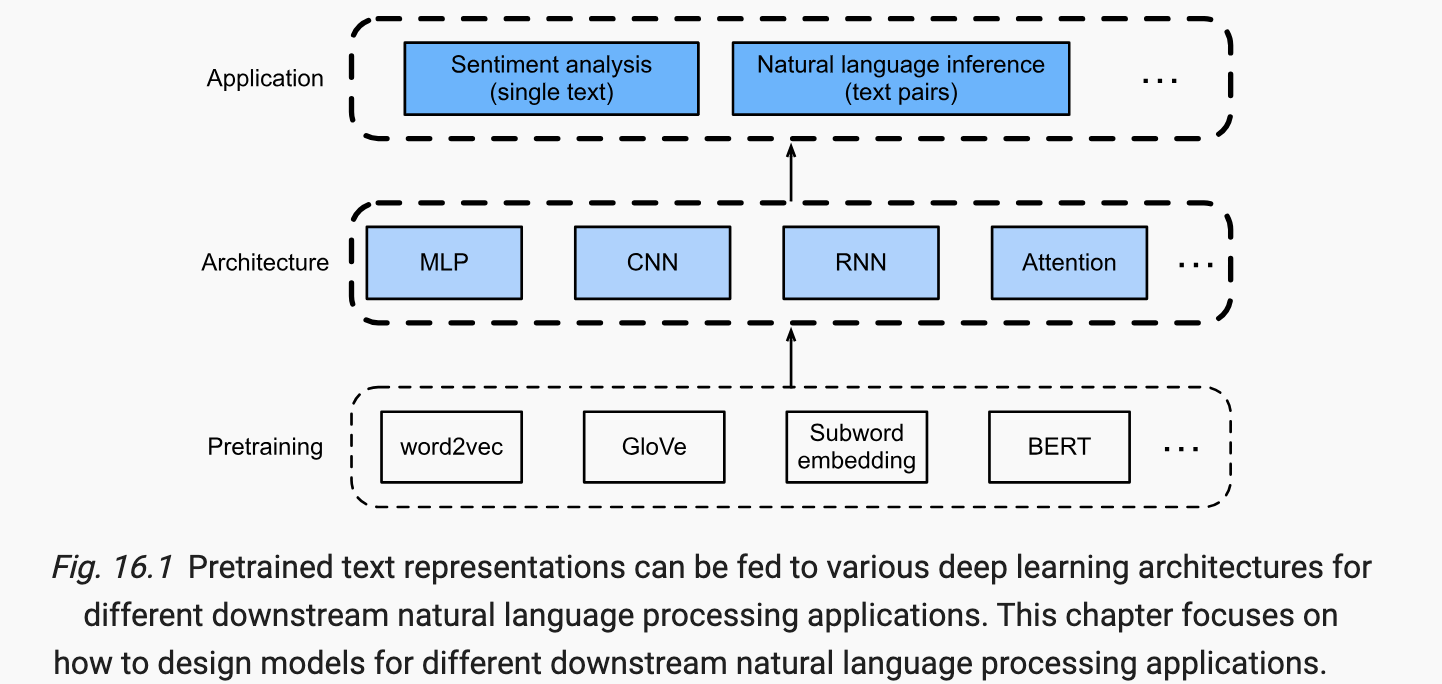

# 16.1. Sentiment Analysis and the Dataset

## 16.1.1. Reading the Dataset

In [3]:
# @save
d2l.DATA_HUB["aclImdb"] = (
    d2l.DATA_URL + "aclImdb_v1.tar.gz",
    "01ada507287d82875905620988597833ad4e0903",
)

data_dir = d2l.download_extract("aclImdb", "aclImdb")

In [4]:
# @save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ("pos", "neg"):
        folder_name = os.path.join(data_dir, "train" if is_train else "test", label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), "rb") as f:
                review = f.read().decode("utf-8").replace("\n", "")
                data.append(review)
                labels.append(1 if label == "pos" else 0)
    return data, labels


train_data = read_imdb(data_dir, is_train=True)
print("# trainings:", len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print("label:", y, "review:", x[:60])

# trainings: 25000
label: 1 review: This Columbo episode is probably noted more for the director
label: 1 review: I wait for each new episode, each re-run with anticipation! 
label: 1 review: This is a must-see documentary movie for anyone who fears th


## 16.1.2. Preprocessing the Dataset

In [ ]:
train_tokens = d2l.tokenize(train_data[0], token="word")
# Treating each word as a token and filtering out words that appear less than 5 times
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=["<pad>"])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

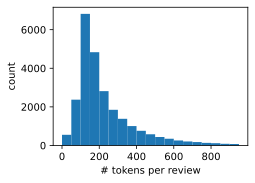

In [6]:
d2l.set_figsize()
d2l.plt.xlabel("# tokens per review")
d2l.plt.ylabel("count")
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [ ]:
# set the length of each review to 500 with truncation and padding
num_steps = 500  # sequence length
train_features = torch.tensor(
    [d2l.truncate_pad(vocab[line], num_steps, vocab["<pad>"]) for line in train_tokens]
)
print(train_features.shape)

torch.Size([25000, 500])


## 16.1.3. Creating Data Iterators

In [8]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print("X:", X.shape, ", y:", y.shape)
    break
print("# batches:", len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## 16.1.4. Putting It All Together

In [2]:
# @save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract("aclImdb", "aclImdb")
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token="word")
    test_tokens = d2l.tokenize(test_data[0], token="word")
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor(
        [
            d2l.truncate_pad(vocab[line], num_steps, vocab["<pad>"])
            for line in train_tokens
        ]
    )
    test_features = torch.tensor(
        [
            d2l.truncate_pad(vocab[line], num_steps, vocab["<pad>"])
            for line in test_tokens
        ]
    )
    train_iter = d2l.load_array(
        (train_features, torch.tensor(train_data[1])), batch_size
    )
    test_iter = d2l.load_array(
        (test_features, torch.tensor(test_data[1])), batch_size, is_train=False
    )
    return train_iter, test_iter, vocab

# 16.2. Sentiment Analysis: Using Recurrent Neural Networks

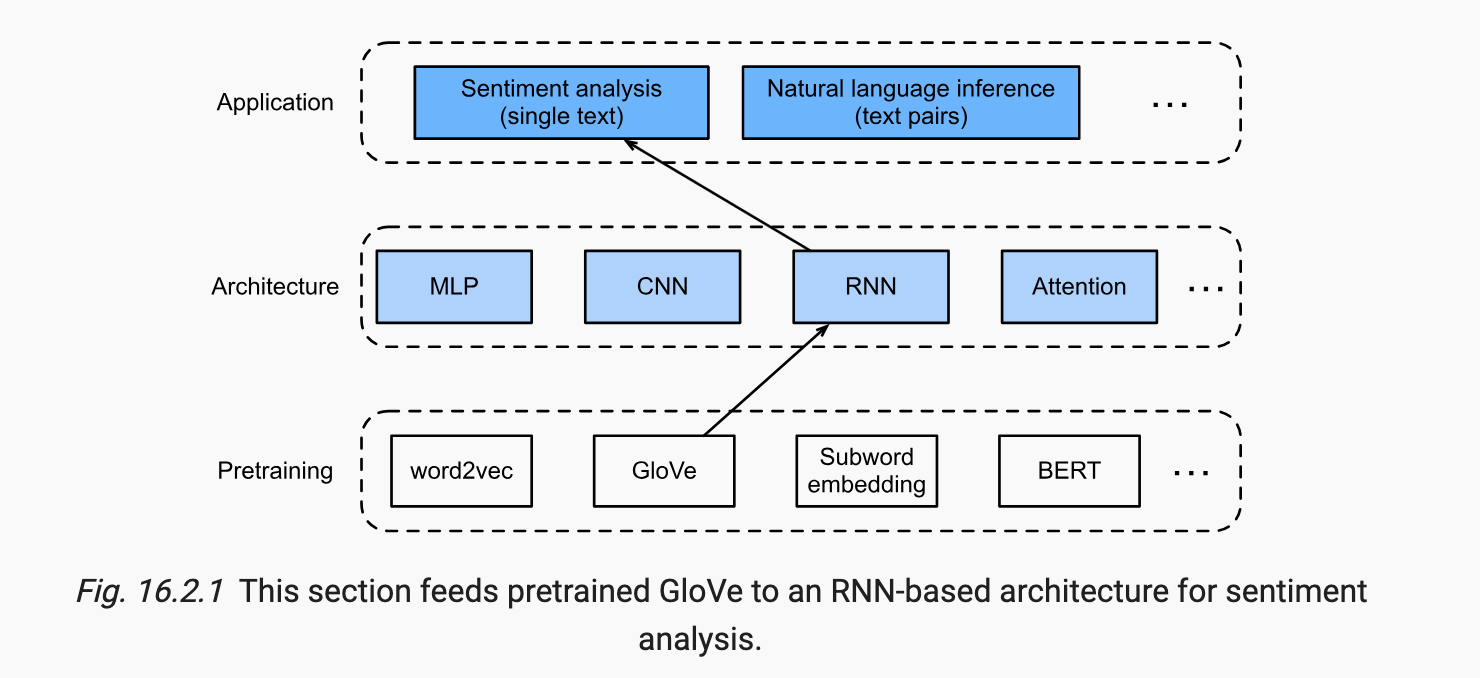

In [9]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 16.2.1. Representing Single Text with RNNs

the hidden states (at the last layer) of the bidirectional LSTM at both the initial and final time steps are concatenated as the representation of the text sequence.

In [10]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(
            embed_size, num_hiddens, num_layers=num_layers, bidirectional=True
        )
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [11]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)


def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])


net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

## 16.2.2. Loading Pretrained Word Vectors

In [12]:
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")

In [13]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [14]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## 16.2.3. Training and Evaluating the Model

loss 0.294, train acc 0.876, test acc 0.842
2525.6 examples/sec on [device(type='cuda', index=0)]


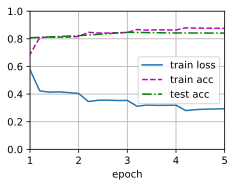

In [15]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [16]:
# @save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return "positive" if label == 1 else "negative"

In [17]:
predict_sentiment(net, vocab, "this movie is so great")

'positive'

In [18]:
predict_sentiment(net, vocab, "this movie is so bad")

'negative'

# 16.3. Sentiment Analysis: Using Convolutional Neural Networks

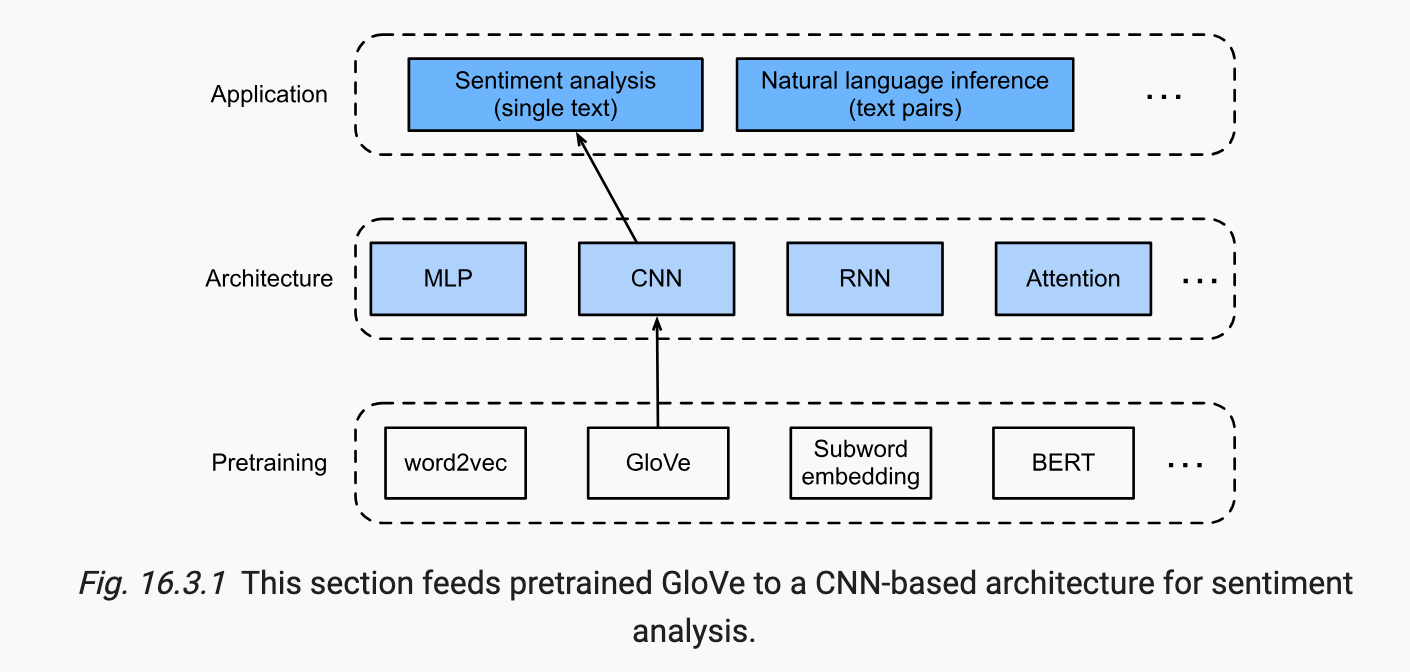
any text sequence as a one-dimensional image

In [19]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 16.3.1. One-Dimensional Convolutions

In [20]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i : i + w] * K).sum()
    return Y

In [21]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations. 

In [ ]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))


X = torch.tensor([[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

## 16.3.3. The textCNN Model

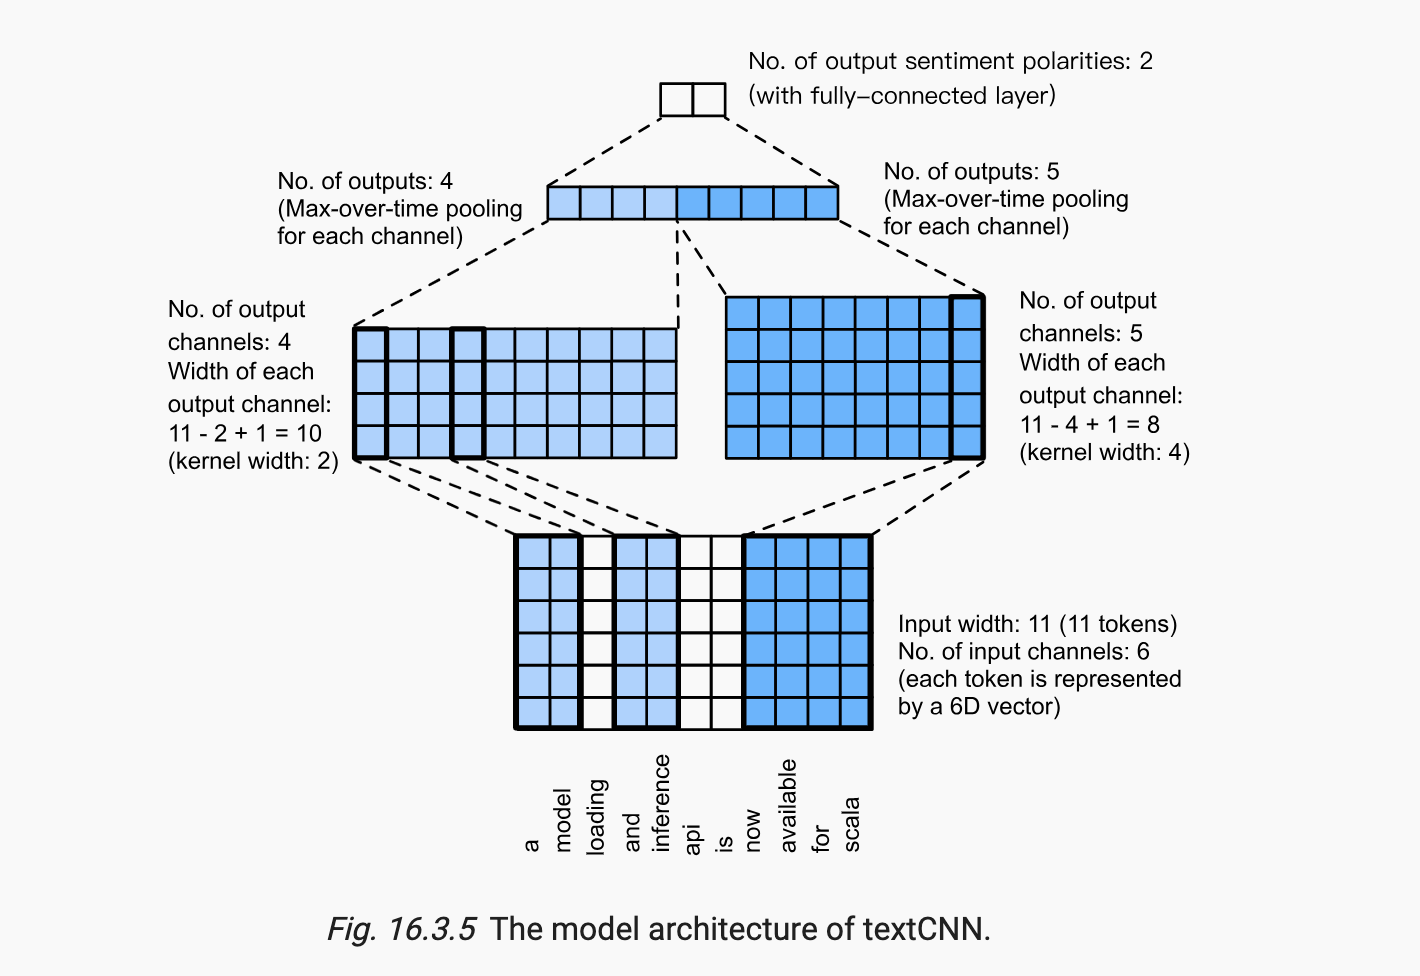

In [23]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat(
            (self.embedding(inputs), self.constant_embedding(inputs)), dim=2
        )
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat(
            [
                torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
                for conv in self.convs
            ],
            dim=1,
        )
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [24]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)


def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)


net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [25]:
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.066, train acc 0.979, test acc 0.872
6850.8 examples/sec on [device(type='cuda', index=0)]


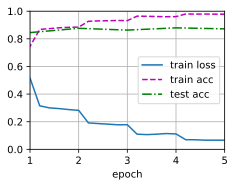

In [26]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [27]:
d2l.predict_sentiment(net, vocab, "this movie is so great")

'positive'

In [28]:
d2l.predict_sentiment(net, vocab, "this movie is so bad")

'negative'

# 16.4. Natural Language Inference and the Dataset

Natural language inference studies whether a hypothesis can be inferred from a premise, where both are a text sequence. In other words, natural language inference determines the logical relationship between a pair of text sequences.  
three types of relationship:
- Entailment: the hypothesis can be inferred from the premise.
- Contradiction: the negation of the hypothesis can be inferred from the premise.
- Neutral: all the other cases.

## 16.4.2. The Stanford Natural Language Inference (SNLI) Dataset

In [29]:
# @save
d2l.DATA_HUB["SNLI"] = (
    "https://nlp.stanford.edu/projects/snli/snli_1.0.zip",
    "9fcde07509c7e87ec61c640c1b2753d9041758e4",
)

data_dir = d2l.download_extract("SNLI")

In [30]:
# @save
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""

    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub("\\(", "", s)
        s = re.sub("\\)", "", s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub("\\s{2,}", " ", s)
        return s.strip()

    label_set = {"entailment": 0, "contradiction": 1, "neutral": 2}
    file_name = os.path.join(
        data_dir, "snli_1.0_train.txt" if is_train else "snli_1.0_test.txt"
    )
    with open(file_name, "r") as f:
        rows = [row.split("\t") for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [33]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print("premise:", x0)
    print("hypothesis:", x1)
    print("label:", y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [34]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [35]:
# @save
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""

    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(
                all_premise_tokens + all_hypothesis_tokens,
                min_freq=5,
                reserved_tokens=["<pad>"],
            )
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print("read " + str(len(self.premises)) + " examples")

    def _pad(self, lines):
        return torch.tensor(
            [
                d2l.truncate_pad(self.vocab[line], self.num_steps, self.vocab["<pad>"])
                for line in lines
            ]
        )

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [36]:
# @save
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract("SNLI")
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(
        train_set, batch_size, shuffle=True, num_workers=num_workers
    )
    test_iter = torch.utils.data.DataLoader(
        test_set, batch_size, shuffle=False, num_workers=num_workers
    )
    return train_iter, test_iter, train_set.vocab

In [37]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

In [38]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


# 16.5. Natural Language Inference: Using Attention

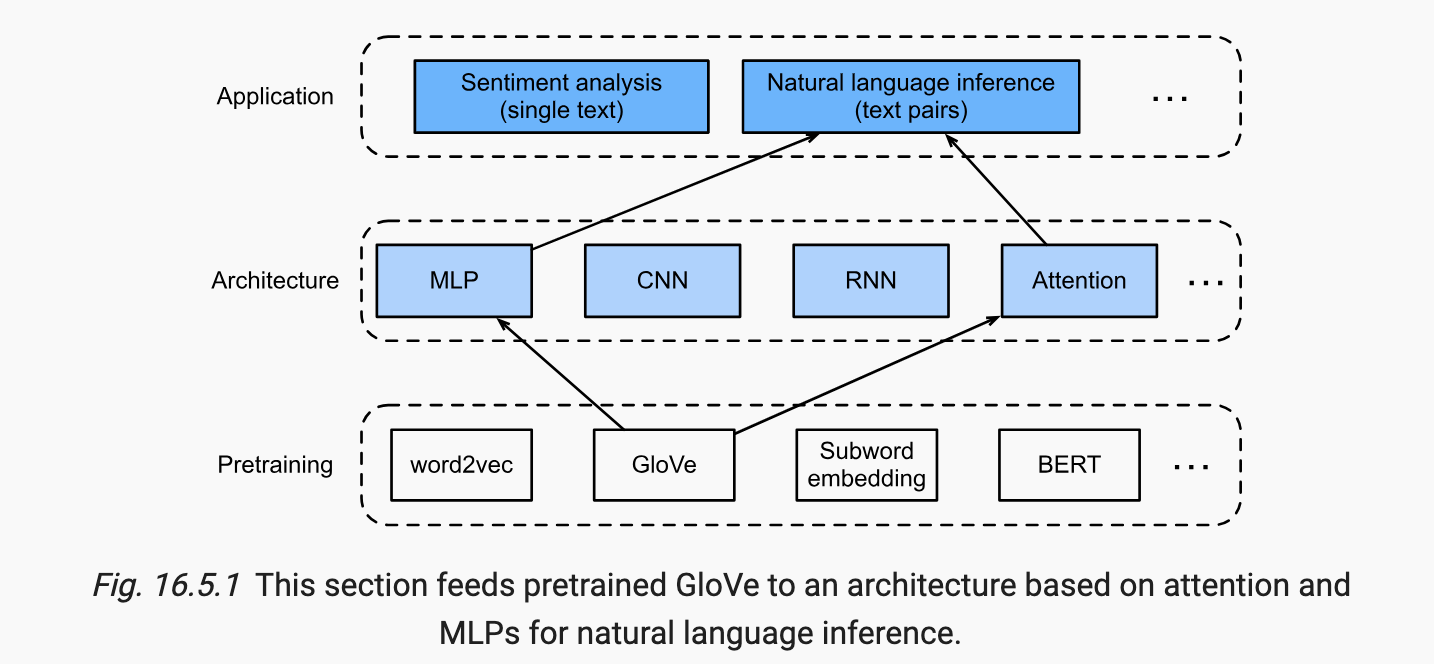

## 16.5.1. The Model

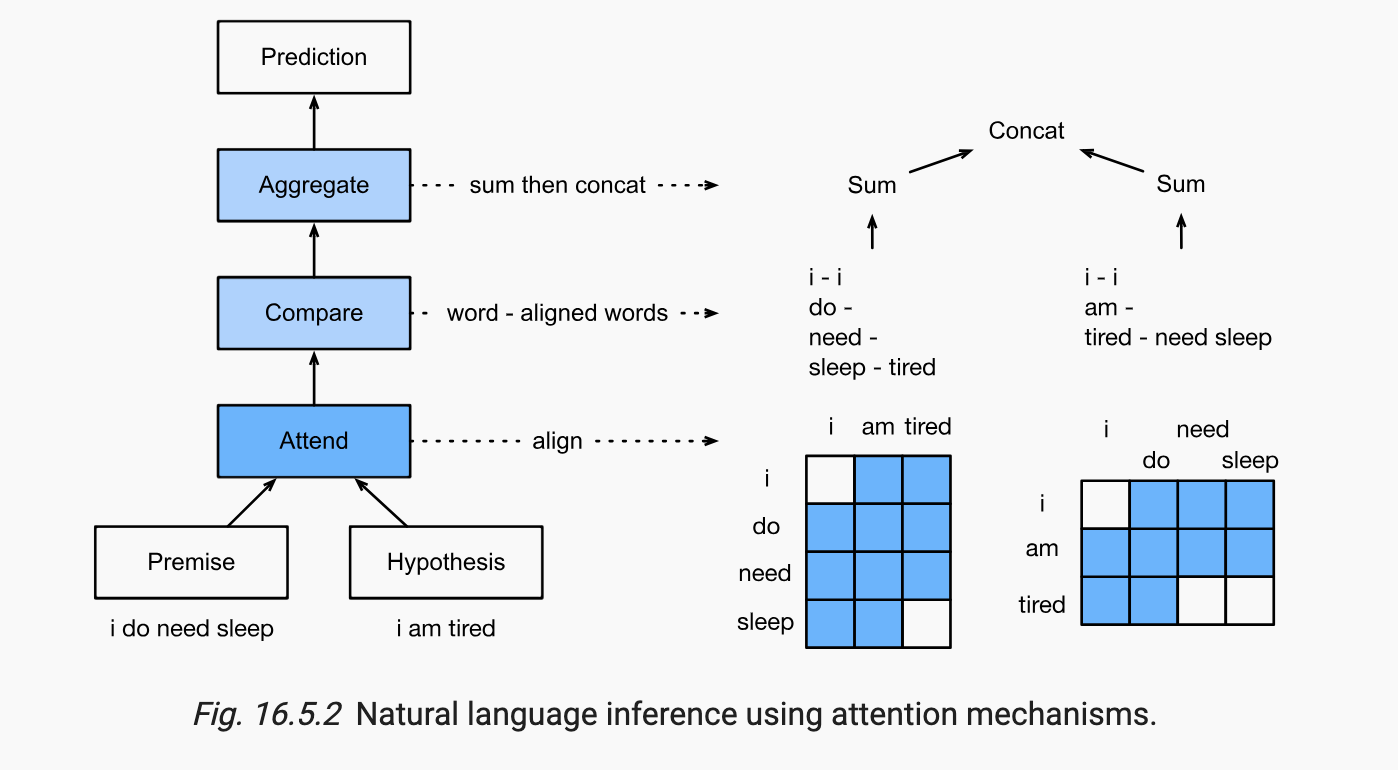

### 16.5.1.1. Attending

In [40]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [41]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

### 16.5.1.2. Comparing

In [42]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### 16.5.1.3. Aggregating

In [43]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [44]:
class DecomposableAttention(nn.Module):
    def __init__(
        self,
        vocab,
        embed_size,
        num_hiddens,
        num_inputs_attend=100,
        num_inputs_compare=200,
        num_inputs_agg=400,
        **kwargs
    ):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## 16.5.2. Training and Evaluating the Model

In [45]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [46]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        [ 0.9747,  1.2276,  0.4538,  ...,  0.2209,  1.7439, -0.8991],
        ...,
        [-0.0205, -0.4512,  0.6993,  ...,  0.0381,  0.2786,  0.2889],
        [-0.2484, -0.2568,  0.0255,  ...,  0.2161, -0.3413,  0.6266],
        [-0.1438,  0.8681, -0.7219,  ...,  0.0553, -0.4339,  0.3486]])

In [47]:
# @save
def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(
        zip(
            *[
                gluon.utils.split_and_load(feature, devices, even_split=False)
                for feature in X
            ]
        )
    )
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

loss 0.495, train acc 0.805, test acc 0.819
32543.7 examples/sec on [device(type='cuda', index=0)]


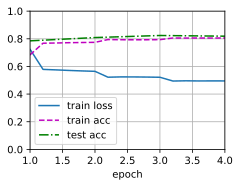

In [48]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [49]:
# @save
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(
        net([premise.reshape((1, -1)), hypothesis.reshape((1, -1))]), dim=1
    )
    return "entailment" if label == 0 else "contradiction" if label == 1 else "neutral"

In [50]:
predict_snli(net, vocab, ["he", "is", "good", "."], ["he", "is", "bad", "."])

'contradiction'

# 16.6. Fine-Tuning BERT for Sequence-Level and Token-Level Applications

## 16.6.1. Single Text Classification

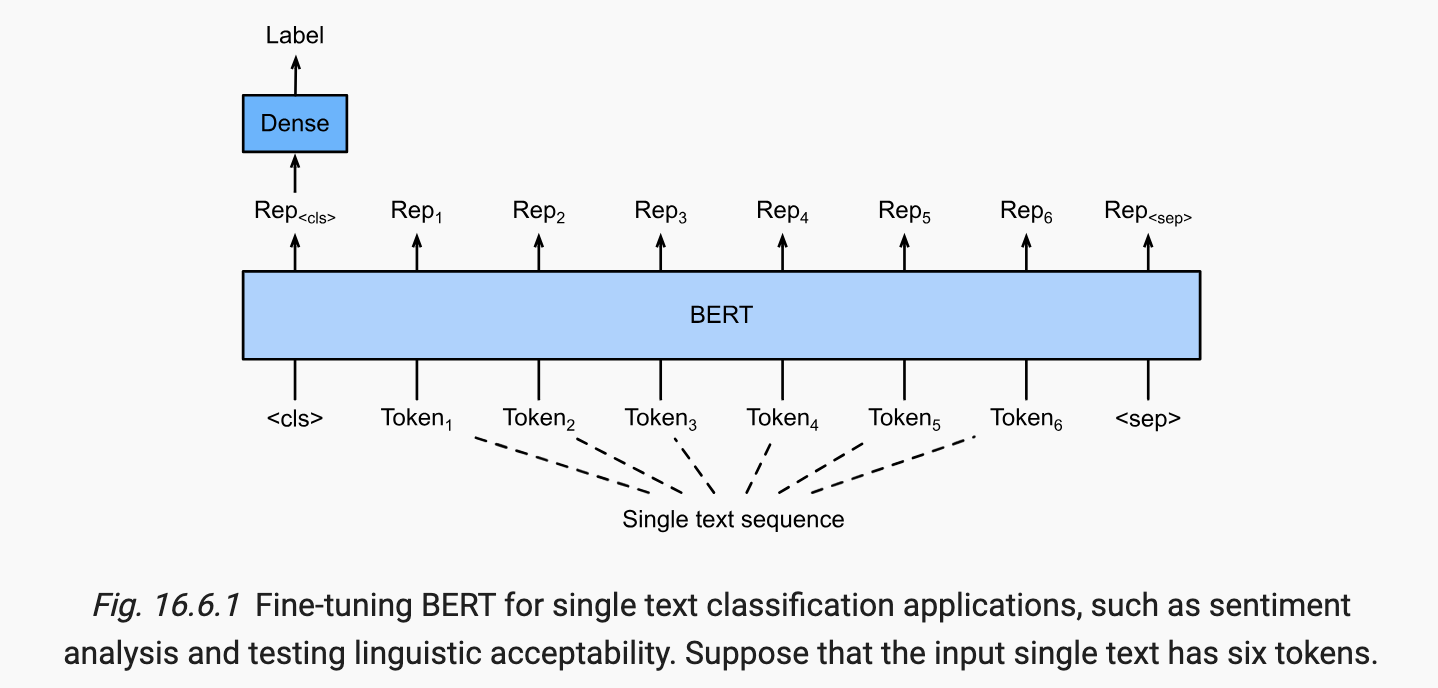

## 16.6.2. Text Pair Classification or Regression

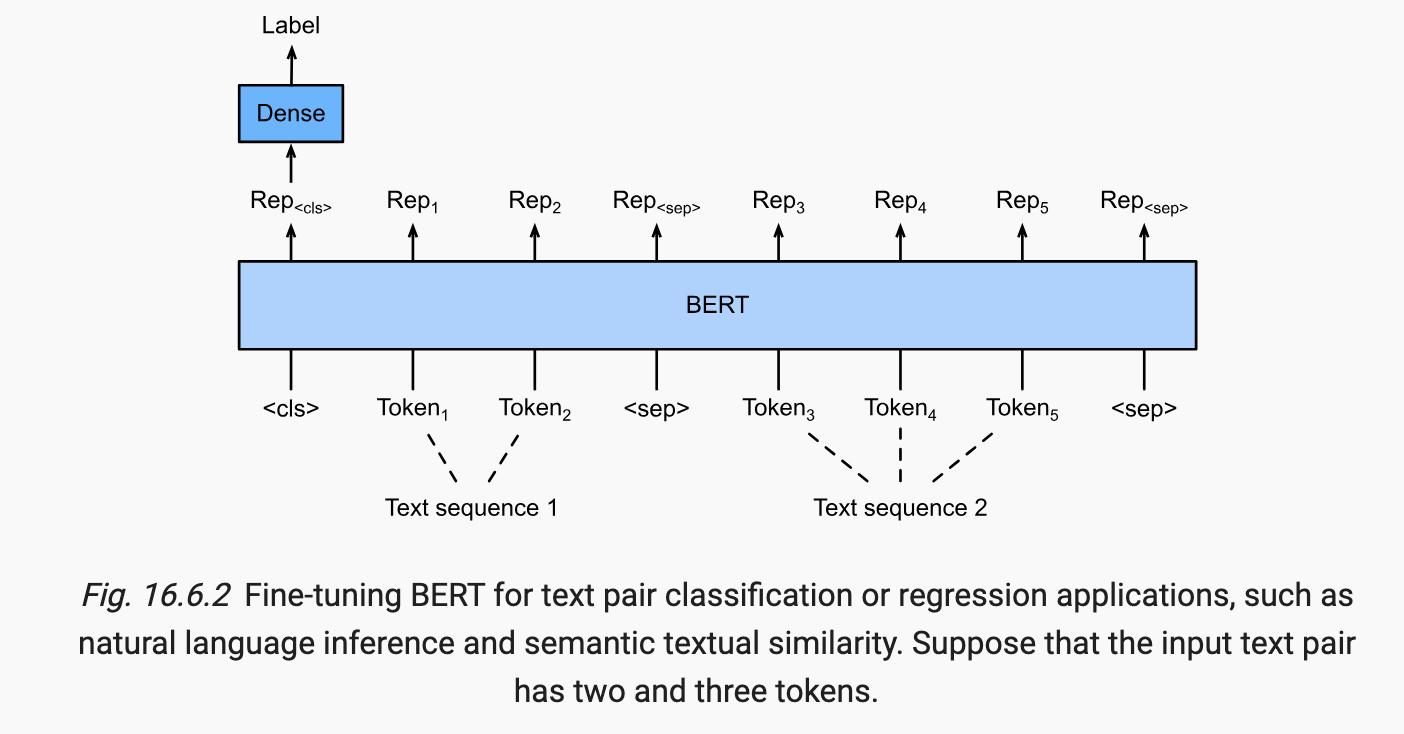

## 16.6.3. Text Tagging

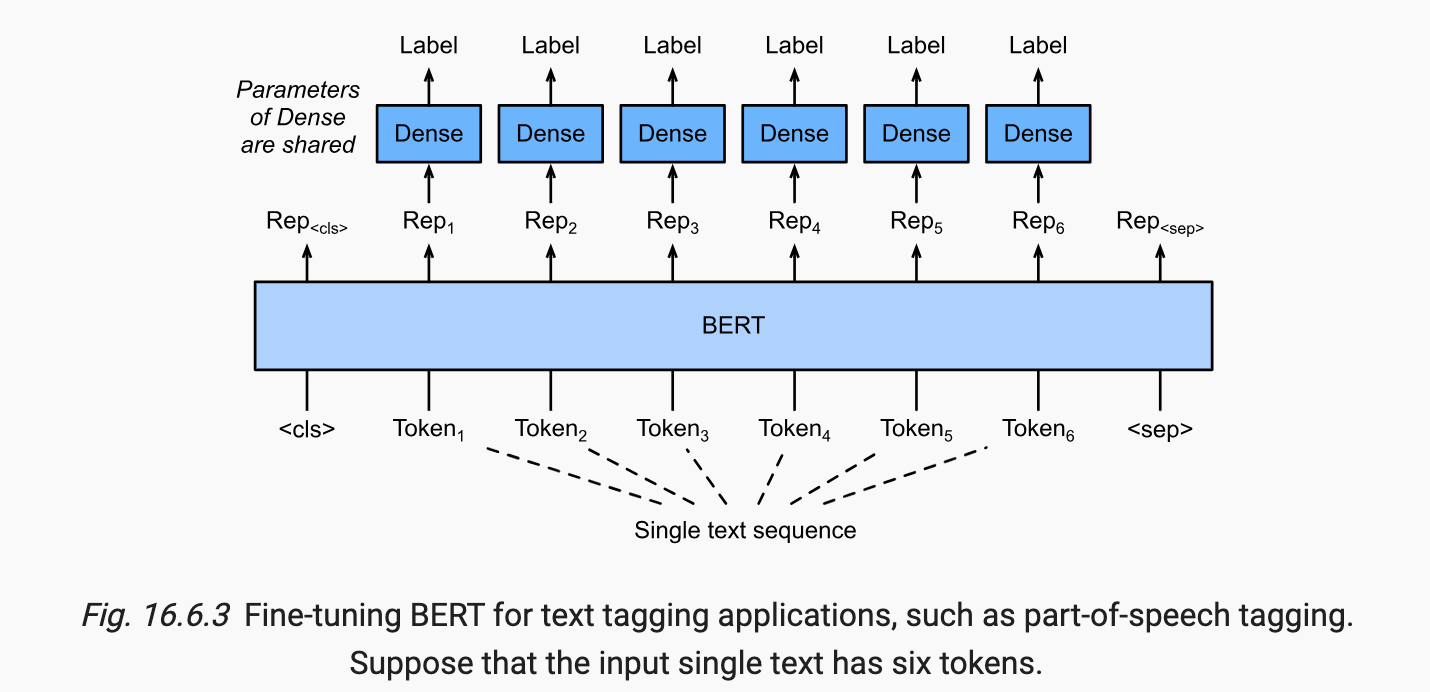

## 16.6.4. Question Answering

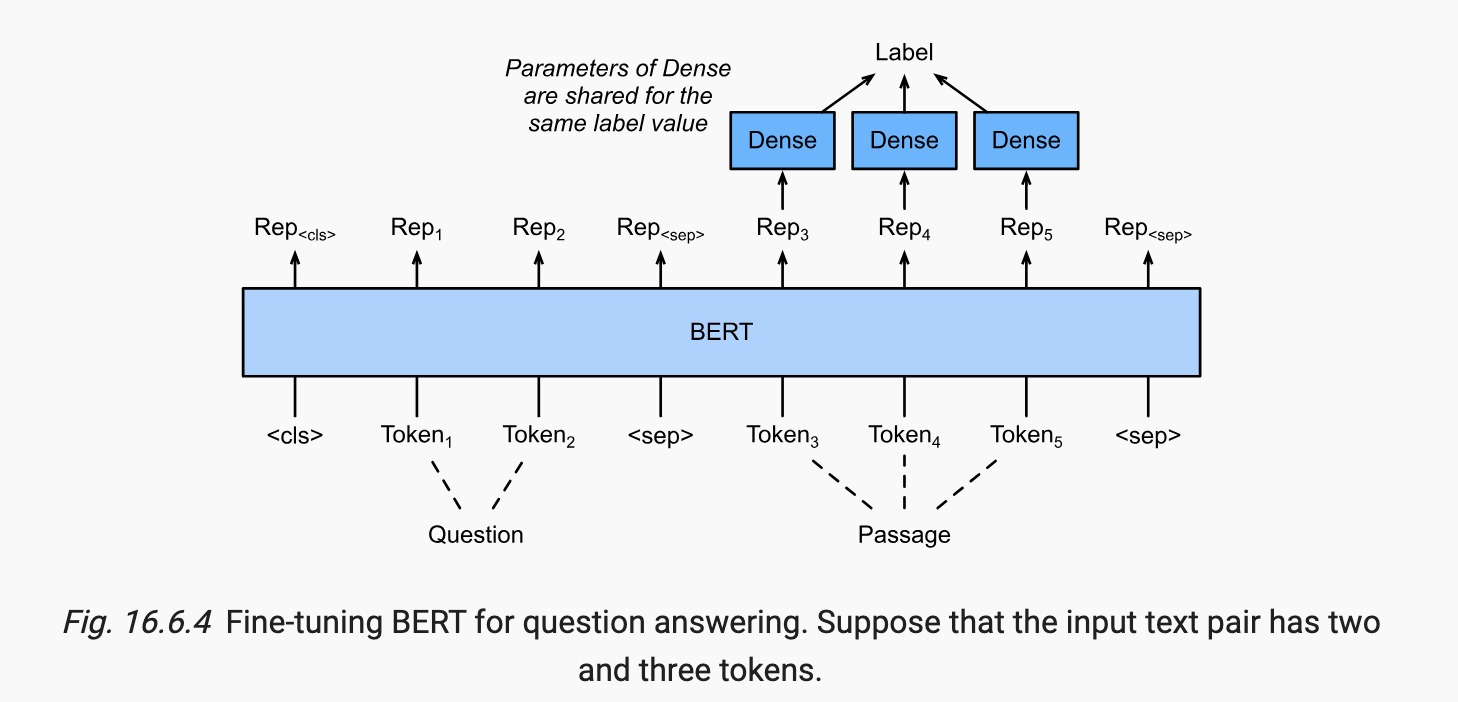

# 16.7. Natural Language Inference: Fine-Tuning BERT

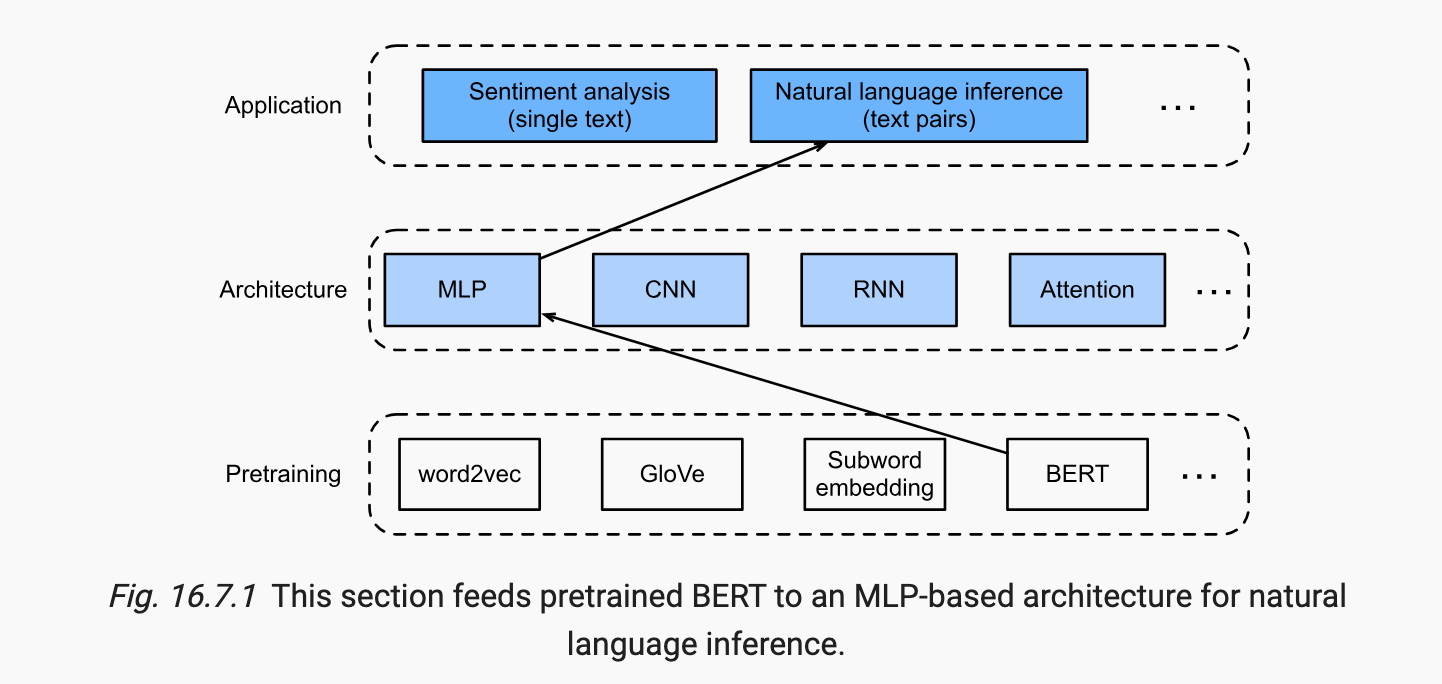

## 16.7.1. Loading Pretrained BERT

In [51]:
d2l.DATA_HUB["bert.base"] = (
    d2l.DATA_URL + "bert.base.torch.zip",
    "225d66f04cae318b841a13d32af3acc165f253ac",
)
d2l.DATA_HUB["bert.small"] = (
    d2l.DATA_URL + "bert.small.torch.zip",
    "c72329e68a732bef0452e4b96a1c341c8910f81f",
)

In [52]:
def load_pretrained_model(
    pretrained_model,
    num_hiddens,
    ffn_num_hiddens,
    num_heads,
    num_blks,
    dropout,
    max_len,
    devices,
):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, "vocab.json")))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab),
        num_hiddens,
        ffn_num_hiddens=ffn_num_hiddens,
        num_heads=4,
        num_blks=2,
        dropout=0.2,
        max_len=max_len,
    )
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir, "pretrained.params")))
    return bert, vocab

In [55]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    "bert.small",
    num_hiddens=256,
    ffn_num_hiddens=512,
    num_heads=4,
    num_blks=2,
    dropout=0.1,
    max_len=512,
    devices=devices,
)

/tmp/ipykernel_90248/573429165.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert.load_state_dict(torch.load(os.path.join(data_dir, "pretrained.params")))


## 16.7.2. The Dataset for Fine-Tuning BERT

In [56]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [p_tokens, h_tokens]
            for p_tokens, h_tokens in zip(
                *[
                    d2l.tokenize([s.lower() for s in sentences])
                    for sentences in dataset[:2]
                ]
            )
        ]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments, self.valid_lens) = self._preprocess(
            all_premise_hypothesis_tokens
        )
        print("read " + str(len(self.all_token_ids)) + " examples")

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (
            torch.tensor(all_token_ids, dtype=torch.long),
            torch.tensor(all_segments, dtype=torch.long),
            torch.tensor(valid_lens),
        )

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab["<pad>"]] * (
            self.max_len - len(tokens)
        )
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (
            self.all_token_ids[idx],
            self.all_segments[idx],
            self.valid_lens[idx],
        ), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [57]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract("SNLI")
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(
    train_set, batch_size, shuffle=True, num_workers=num_workers
)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


## 16.7.3. Fine-Tuning BERT

In [58]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [59]:
net = BERTClassifier(bert)

loss 0.518, train acc 0.792, test acc 0.781
3631.9 examples/sec on [device(type='cuda', index=0)]


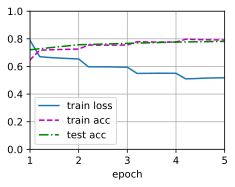

In [60]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)